In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from pprint import pprint

In [2]:
## Getting data.
# df_train = pd.read_parquet('https://github.com/BhardwajAnshul/NER-Project/blob/main/data/WIESP2022-NER-TRAINING.parquet?raw=true')
df_train = pd.read_parquet('https://github.com/BhardwajAnshul/NER-Project/blob/main/WIESP_TRAINING_PREPROCESSED.parquet?raw=true')
# df_train = pd.read_parquet('https://github.com/BhardwajAnshul/NER-Project/blob/main/WIESP_TRAINING_SPLITTED.parquet?raw=true')
# df_val = pd.read_parquet('https://github.com/BhardwajAnshul/NER-Project/blob/main/data/WIESP2022-NER-DEV.parquet?raw=true')
# df_test = pd.read_parquet('https://github.com/BhardwajAnshul/NER-Project/blob/main/data/WIESP2022-NER-VALIDATION-NO-LABELS.parquet?raw=true')
print(df_train.head())

               bibcode  label_studio_id  ner_ids ner_tags   section  \
0  2019MNRAS.486.5558S              487       62        O  fulltext   
1  2019MNRAS.486.5558S              487       62        O  fulltext   
2  2019MNRAS.486.5558S              487       62        O  fulltext   
3  2019MNRAS.486.5558S              487       62        O  fulltext   
4  2019MNRAS.486.5558S              487       62        O  fulltext   

       tokens                         unique_id  is_starttoken  sentence_id  
0      Whilst  fulltext_487_2019MNRAS.486.5558S              0            0  
1           a  fulltext_487_2019MNRAS.486.5558S              0            0  
2  reasonable  fulltext_487_2019MNRAS.486.5558S              0            0  
3    harmonic  fulltext_487_2019MNRAS.486.5558S              0            0  
4         fit  fulltext_487_2019MNRAS.486.5558S              0            0  


In [3]:
df_train.columns

Index(['bibcode', 'label_studio_id', 'ner_ids', 'ner_tags', 'section',
       'tokens', 'unique_id', 'is_starttoken', 'sentence_id'],
      dtype='object')

In [4]:
print('Training Data has shape: ', df_train.shape)

Training Data has shape:  (690871, 9)


In [5]:
df_train = df_train[~df_train['tokens'].isin(list('?$#@./|:()",;[]{}-'))]
print('Training Data has shape: ', df_train.shape)

Training Data has shape:  (587676, 9)


In [6]:
## Creating an index mapping for easier understanding.
def index_mapper(df, train=False):
  if not train:
      num_sentences = df['bibcode'].unique()
      index = np.arange(1, len(num_sentences)+1, 1)
      index_dict = dict(zip(num_sentences, index))

      index_mapping = [index_dict[bibcode] for bibcode in df['bibcode']]
      df['index'] = index_mapping
      df.set_index('index', inplace=True)
  else:
      df.set_index('sentence_id', inplace=True)
  return df

df_train = index_mapper(df_train, train=False)
# df_val = index_mapper(df_val)
# df_test = index_mapper(df_test)

In [7]:
## Choose only necessary columns.
df_train_sel = df_train[['tokens', 'ner_tags']]
# df_val_sel = df_val[['tokens', 'ner_tags']]
# df_test_sel = df_test[['tokens']]
df_train_sel.head()

,tokens,ner_tags
index,,
1,Whilst,O
1,a,O
1,reasonable,O
1,harmonic,O
1,fit,O


In [8]:
classes = list(df_train_sel.ner_tags.unique())
classes_without_o = classes[1:]

In [9]:
df_train_sel.isna().sum()

tokens      0
ner_tags    0
dtype: int64

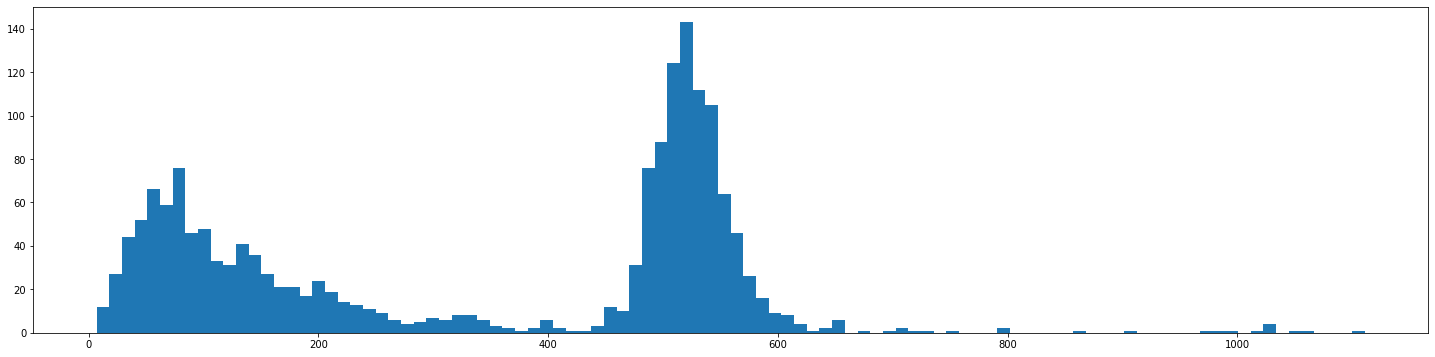

The number of sentences in the dataframe are:  1723


In [10]:
# Plot length of the sentences.
index, length = np.unique(df_train_sel.index, return_counts=True)
fig, ax = plt.subplots(figsize=[25,6])
N, bins, patches = ax.hist(length, bins=100)
plt.show()

print('The number of sentences in the dataframe are: ', len(length))   ## Number of sentences

In [11]:
## Finding suitable sentences.
# b1 = length>10
# b2 = length<200
# b3 = length>420
# b4 = length<600

b1 = length>10
b2 = length<620

# b5 = np.logical_and(b1, b2)
# b6 = np.logical_and(b3, b4)
# b7 = np.logical_or(np.logical_and(b1, b2), np.logical_and(b3, b4))

b7 = np.logical_and(b1, b2)

In [12]:
## Chossing neccessary sentences.
index = index[b7]
length = length[b7]
df_train_sel = df_train_sel.loc[index]
print('The number of sentences in the dataframe are: ', len(length))   ## Number of sentences

The number of sentences in the dataframe are:  1687


In [13]:
# ## Splitting Data into Training and Validation.
# index = np.unique(df_train.index)

# train_index, val_index = train_test_split(index, train_size=0.8, random_state=1)

# df_train = df_train.loc[train_index]
# df_val = df_train.loc[val_index]

In [14]:
df_train_bert = df_train_sel.reset_index()
df_train_bert.head()

,index,tokens,ner_tags
0,1,Whilst,O
1,1,a,O
2,1,reasonable,O
3,1,harmonic,O
4,1,fit,O


In [15]:
## Encoding the NER labels.
le = LabelEncoder()
df_train_sel['ner_tags'] = le.fit_transform(df_train_sel['ner_tags'])
# df_val_sel['ner_tags'] = le.transform(df_val_sel['ner_tags'])
df_train_sel.head()

,tokens,ner_tags
index,,
1,Whilst,62
1,a,62
1,reasonable,62
1,harmonic,62
1,fit,62


In [16]:
## Because padded variable has to be kept as 0 and not -1. Else label encode would trouble it!
df_train_sel.ner_tags += 1

In [17]:
df_train_sel.head()

,tokens,ner_tags
index,,
1,Whilst,63
1,a,63
1,reasonable,63
1,harmonic,63
1,fit,63


In [18]:
# ## Remove characters
# df_train.tokens = df_train.tokens.str.replace("[^a-zA-Z0-9 ]",'')
# df_val.tokens = df_val.tokens.str.replace("[^a-zA-Z0-9 ]",'')

In [19]:
# Tokenize the words
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='?$#@./|:()",;[]{}-',
                                                  lower=False, 
                                                  split=' ',
                                                  num_words=2000,
                                                  oov_token='<UNK>')       # Initialize

# tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, split=' ') # Initialize
tokenizer.fit_on_texts(df_train_sel.tokens.values) # Fit on training data

In [20]:
# Transform to numeric
tokens_train  = tokenizer.texts_to_sequences(df_train_sel.tokens.values)
# tokens_val    = tokenizer.texts_to_sequences(df_val_sel.tokens.values)
# tokens_test   = tokenizer.texts_to_sequences(df_test_sel.tokens.values)

In [21]:
# Remove empty elements from training data
b = np.array([token!=[] for token in tokens_train])
df_train_sel = df_train_sel.iloc[b,:]
tokens_train = np.array(tokens_train)[b]

# # Remove empty elements from validation data
# b = np.array([token!=[] for token in tokens_val])
# df_val_sel = df_val_sel.iloc[b,:]
# tokens_val = np.array(tokens_val)[b]

# # Remove empty elements from test data
# b = np.array([token!=[] for token in tokens_test])
# df_test_sel = df_test_sel.iloc[b,:]
# tokens_test = np.array(tokens_test)[b]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [22]:
tokens_train

array([list([1]), list([8]), list([1461]), ..., list([1620]), list([3]),
       list([209])], dtype=object)

In [23]:
word_to_token = tokenizer.word_index

In [24]:
word_to_token

{'<UNK>': 1,
 'the': 2,
 '<NUM>': 3,
 'of': 4,
 'and': 5,
 'in': 6,
 'to': 7,
 'a': 8,
 'is': 9,
 'for': 10,
 '<YEAR>': 11,
 'by': 12,
 'with': 13,
 'The': 14,
 'that': 15,
 'from': 16,
 'et': 17,
 'al': 18,
 'are': 19,
 'at': 20,
 'as': 21,
 'we': 22,
 'on': 23,
 'We': 24,
 'this': 25,
 'be': 26,
 'This': 27,
 'which': 28,
 '=': 29,
 'an': 30,
 'data': 31,
 'was': 32,
 'our': 33,
 'In': 34,
 'mass': 35,
 'have': 36,
 'also': 37,
 'not': 38,
 'M': 39,
 'A': 40,
 'support': 41,
 'can': 42,
 'Figure': 43,
 'has': 44,
 'model': 45,
 'than': 46,
 'e': 47,
 'University': 48,
 'between': 49,
 'Fig': 50,
 'stars': 51,
 'work': 52,
 'H': 53,
 'time': 54,
 'National': 55,
 'grant': 56,
 'thank': 57,
 'two': 58,
 'Research': 59,
 'observations': 60,
 'their': 61,
 'or': 62,
 'supported': 63,
 'these': 64,
 'Science': 65,
 'line': 66,
 'using': 67,
 'were': 68,
 'it': 69,
 'under': 70,
 'density': 71,
 'field': 72,
 'galaxies': 73,
 'use': 74,
 'used': 75,
 'see': 76,
 'where': 77,
 'observed': 7

In [25]:
df_train_sel.tokens = tokens_train
# df_val_sel.tokens = tokens_val
# df_test_sel.tokens = tokens_test
print(df_train_sel.head())

       tokens  ner_tags
index                  
1         [1]        63
1         [8]        63
1      [1461]        63
1         [1]        63
1       [166]        63


In [26]:
# df_train_sel.tokens = df_train_sel.tokens[0]
# df_val_sel.tokens = df_val_sel.tokens[0]
# df_test_sel.tokens = df_test_sel.tokens[0]

In [27]:
# df_train_sel.tokens = df_train_sel.tokens.apply(lambda x: x[0])
# df_val_sel.tokens = df_val_sel.tokens.apply(lambda x: x[0])
# df_test_sel.tokens = df_test_sel.tokens.apply(lambda x: x[0])

In [28]:
df_train_sel.tokens = df_train_sel.tokens.apply(lambda x: x[0])
# df_val_sel.tokens = df_val_sel.tokens.apply(lambda x: x[0])
# df_test_sel.tokens = df_test_sel.tokens.apply(lambda x: x[0])
df_train_sel.head()

,tokens,ner_tags
index,,
1,1,63
1,8,63
1,1461,63
1,1,63
1,166,63


In [29]:
df_train_sel = df_train_sel.astype(str)
# df_val_sel = df_val_sel.astype(str)
# df_test_sel = df_test_sel.astype(str)

In [30]:
df_train_concat = df_train_sel.groupby(df_train_sel.index).agg(lambda x: ' '.join(x))
# df_val_concat = df_val_sel.groupby(df_val_sel.index).agg(lambda x: ' '.join(x))
# df_test_concat = df_test_sel.groupby(df_test_sel.index).agg(lambda x: ' '.join(x))

In [31]:
df_train_concat

,tokens,ner_tags
index,,
1,1 8 1461 1 166 7 2 1 31 42 26 1 67 25 333 69 4...,63 63 63 63 63 63 63 16 63 63 63 63 63 63 63 6...
2,449 1542 2 373 992 4 2 1 19 1 304 25 342 779 2...,63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 6...
3,482 14 280 57 30 226 1824 10 143 5 434 15 1 33...,63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 2...
4,1 704 86 41 16 107 1685 56 3 349 56 425 3 5 2 ...,23 63 63 63 63 22 14 45 45 22 63 14 14 63 63 2...
5,482 24 57 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 10 1...,63 63 63 23 54 23 54 54 23 54 23 54 23 54 23 5...
...,...,...
1719,3 3 9 1 473 191 1 1 1 20 1 49 1946 788 5 8 687...,63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 6...
1720,1860 3 253 3 3 272 108 72 608 4 1 112 3 5 10 3...,63 63 63 63 63 63 63 63 63 63 2 33 33 63 63 63...
1721,482 24 19 365 7 2 226 1 10 524 1248 1433 1302 ...,63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 6...


In [32]:
df_train_concat.tokens = df_train_concat.tokens.apply(lambda x: x.split(' '))
df_train_concat.ner_tags = df_train_concat.ner_tags.apply(lambda x: x.split(' '))
# df_val_concat.tokens = df_val_concat.tokens.apply(lambda x: x.split(' '))
# df_val_concat.ner_tags = df_val_concat.ner_tags.apply(lambda x: x.split(' '))
# df_test_concat.tokens = df_test_concat.tokens.apply(lambda x: x.split(' '))

In [33]:
print('Training Set Shape after Concatenating Sentences: ', df_train_concat.shape)
# print('Validation Set Shape after Concatenating Sentences: ', df_val_concat.shape)
# print('Test Set Shape after Concatenating Sentences: ', df_test_concat.shape)
print(df_train_concat.head())

Training Set Shape after Concatenating Sentences:  (1687, 2)
                                                  tokens  \
index                                                      
1      [1, 8, 1461, 1, 166, 7, 2, 1, 31, 42, 26, 1, 6...   
2      [449, 1542, 2, 373, 992, 4, 2, 1, 19, 1, 304, ...   
3      [482, 14, 280, 57, 30, 226, 1824, 10, 143, 5, ...   
4      [1, 704, 86, 41, 16, 107, 1685, 56, 3, 349, 56...   
5      [482, 24, 57, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   

                                                ner_tags  
index                                                     
1      [63, 63, 63, 63, 63, 63, 63, 16, 63, 63, 63, 6...  
2      [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6...  
3      [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6...  
4      [23, 63, 63, 63, 63, 22, 14, 45, 45, 22, 63, 1...  
5      [63, 63, 63, 23, 54, 23, 54, 54, 23, 54, 23, 5...  


In [34]:
# df_train_concat['length'] = df_train_concat.tokens.apply(lambda x: len(x))
# df_val_concat['length'] = df_val_concat.tokens.apply(lambda x: len(x))

In [35]:
# df_train_concat.head()

In [36]:
# ## Sorting training and validation dataset
# df_train_concat = df_train_concat.sort_values('length')
# df_val_concat = df_val_concat.sort_values('length')
# df_train_concat.head()

In [37]:
# df_train_concat.drop('length', axis=1, inplace=True)
# df_val_concat.drop('length', axis=1, inplace=True)
# df_train_concat

In [38]:
train_sentences = df_train_concat.tokens
train_tags = df_train_concat.ner_tags

In [39]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(train_sentences, train_tags, test_size=0.1, random_state=1)
print(train_sentences.shape)
print(test_sentences.shape)

(1518,)
(169,)


In [40]:
train_sentences.iloc[0][:10]

['482', '24', '57', '133', '1', '10', '219', '143', '5', '235']

In [41]:
train_sentences = [list(map(int, sentence)) for sentence in train_sentences]
train_tags = [list(map(int, sentence)) for sentence in train_tags]
test_sentences = [list(map(int, sentence)) for sentence in test_sentences]
test_tags = [list(map(int, sentence)) for sentence in test_tags]

In [42]:
train_sentences[0][:10]

[482, 24, 57, 133, 1, 10, 219, 143, 5, 235]

In [43]:
# Your code here

# Helper Code
batch_size = 4
train_shuffle_buffer_size = len(train_sentences)
validation_shuffle_buffer_size = len(test_sentences)

# Fill the required cells to complete the function
def transform_pad(input, output):
    
    # Pad the inputs
    input  = input.to_tensor(default_value=0, shape=[None, None])
#     input = tf.reverse(input, axis=[-1])
    
    # Pad the outputs
    output = output.to_tensor(default_value=0, shape=[None, None])
#     output = tf.reverse(output, axis=[-1])
    
    return input, output

# Use tensorflow ragged constants to get the ragged version of data
# train_sentences = tf.keras.preprocessing.sequence.pad_sequences(train_sentences, padding="pre")
# train_tags = tf.keras.preprocessing.sequence.pad_sequences(train_tags, padding="pre")
# test_sentences = tf.keras.preprocessing.sequence.pad_sequences(test_sentences, padding="pre")
# test_tags = tf.keras.preprocessing.sequence.pad_sequences(test_tags, padding="pre")

train_processed_x = tf.ragged.constant(train_sentences)
validate_processed_x = tf.ragged.constant(test_sentences)
train_processed_y = tf.ragged.constant(train_tags)
validate_processed_y = tf.ragged.constant(test_tags)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
#validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

print("train_data", train_data)
print("validation_data", validation_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [44]:
# # Your code here

# # Helper Code
# batch_size = 4
# train_shuffle_buffer_size = len(train_sentences)
# validation_shuffle_buffer_size = len(test_sentences)

# # Pad the data.
# def transform_pad(input):
#     input  = input.to_tensor(default_value=0, shape=[None, None])
#     return input

# # Use tensorflow ragged constants to get the ragged version of data
# train_processed_x = tf.ragged.constant(train_sentences)
# validate_processed_x = tf.ragged.constant(test_sentences)
# train_processed_y = tf.ragged.constant(train_tags)
# validate_processed_y = tf.ragged.constant(test_tags)

# # Create TF Dataset
# x_train = tf.data.Dataset.from_tensor_slices(train_processed_x)
# y_train = tf.data.Dataset.from_tensor_slices(train_processed_y)
# x_val = tf.data.Dataset.from_tensor_slices(train_processed_x)
# y_val = tf.data.Dataset.from_tensor_slices(train_processed_y)

# #############
# # Train data
# #############
# # Apply all data processing logic
# train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
# train_data = train_data.batch(batch_size)
# train_data = train_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
# train_data = train_data.prefetch(tf.data.AUTOTUNE)

# ##################
# # Validation data
# ##################
# # Apply all data processing logic
# #validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
# validation_data = validation_data.batch(batch_size)
# validation_data = validation_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
# validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

# print("train_data", train_data)
# print("validation_data", validation_data)

In [45]:
# View some data from tf dataset
for input_f, output_f in train_data.take(2):
  print(input_f.shape)
  print(input_f[0])
#   print(input_b[0])
  print("************************")
  print(output_f.shape)
  print(output_f[0])
#   print(output_b[0])

(4, 586)
tf.Tensor(
[   4  611    1   91    1    6    2  395 1375  187    2  381 1891 1268
  362   10    1    1  444    1    4  431   53  351  139  102  705   20
    2 1056 1383    4    1    3  931    8  431 1087    7    1    2 1638
   13    1   85  197    5  465 1043  375   93  773   27    6  886    7
    1   16  884 1095    1    4 1659   91   28  769   30  367   84    1
    1    4  445   85  197   24  499  765   15   69    9  137 1305    7
  990    1    1   23    8  419  920  187  799  312  740    6    8  138
  148   36    8  295   66    4  857  420    4 1827   51    3    3    1
    1  841    1    1   10    1    3   36   96 1121   15  153   38    1
    8  375   85   20   81 1224  170  712    9    2 1153    1    4    8
  427 1471   85   62 1088  558   12   30    1    1   17   18   11    1
   17   18   11   34    2  427 1471    1  712    1   17   18   11    8
  700   35    4    3    3    3   39  267    9  706 1128   30    1  104
   26  303    7   26  705  136    8  375   93  205   99  

In [46]:
## Import libraries required to load Word2Vec embeddings without running out of RAM on Colab.
import gzip
import json

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

In [47]:
# Your code here

## Download Word2Vec.
# !wget https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz

In [48]:
## Read the Word2Vec embeddings.
## Ref: https://colab.research.google.com/github/shankygupta79/GoogleCollabFiles/blob/master/Word2Vec.ipynb
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [57]:
vocab = list(word_to_token.keys())[:2000]
word2vec_vocab = list(word_vectors.vocab)
common_words = list(set(vocab) & set(word2vec_vocab))
print('Number of common words in Word2Vec and IMDB tokens are: ', len(common_words))

Number of common words in Word2Vec and IMDB tokens are:  1952


In [55]:
## Creating a use-friendly dictionary for embeddings of all the common words.
embedding_dict = {word: word_vectors[word] for word in common_words if word != '<UNK>'}

## Add the updated UNK token embeddings.
embedding_dict['<UNK>'] = np.random.uniform(low=-1, high=1, size=(300,))

print(len(embedding_dict))

In [58]:
## Create embedding_dict, a dictionary with tokens, as presented in the training data, as keys
embedding_dict_tokens = dict()
vocab_tokens = []

for word in vocab:
  token = word_to_token[word]
  if word not in common_words:
    embedding_dict_tokens[token] = embedding_dict['<UNK>']   ## choosing the <UNK> embeddings for words in top 5000 but not in Word2Vec
  else:
    embedding_dict_tokens[token] = embedding_dict[word]
    vocab_tokens.append(token)

In [71]:
## Create embedding matrix which the index being the token number and the 300 columns representing embeddings
vocab_size = len(embedding_dict_tokens)
embedding_matrix = np.zeros(shape=(vocab_size,300))

for token_num in range(vocab_size):
  embedding_matrix[token_num] = embedding_dict_tokens[token_num+1]

embedding_matrix.shape

(2000, 300)

In [73]:
# Your code here

hidden_size_LSTM = 150
hidden_size_Dense = 150

def build_model():

  ## ---------------------------------------------------------------------------
  ## FORWARD LAYER -------------------------------------------------------------
  ## ---------------------------------------------------------------------------

  ## Define input layer.
  inputs_f = tf.keras.Input(shape=[None])


  ## Embedding Layer for forward.
  embedding_layer_f = tf.keras.layers.Embedding(input_dim=2000,
                                                output_dim=300,
                                                weights=[embedding_matrix],
                                                # input_length=max_length,
                                                trainable=False,
                                                mask_zero=True)

  ## Create a forward LSTM.
  RNN1_layer_f = tf.keras.layers.LSTM(hidden_size_LSTM, return_sequences=True)


  ## Create a dense layer for simulating the highway layer rather than using it here.
  dense_layer_f = tf.keras.layers.Dense(units=hidden_size_Dense, activation='linear', use_bias=False)


  ## Create an additive layer.
  additive_layer_f = tf.keras.layers.Add()


  ## Create second forward LSTM.
  RNN2_layer_f = tf.keras.layers.LSTM(hidden_size_LSTM, return_sequences=True)


  ## Pass Inputs ---------------------------------------------------------------

  embedding_f = embedding_layer_f(inputs_f)   ## Get forward and backward embeddings.
  r_f = RNN1_layer_f(embedding_f)             ## Get LSTM outputs.
  z_f = dense_layer_f(embedding_f)            ## Get Dense layer outputs.
  # h_int_f = additive_layer_f([r_f, z_f])      ## Get addition of LSTM and Dense Layer outputs.
  h_f = RNN2_layer_f(r_f + z_f)                 ## Get LSTM2 outputs.
  


#   ## ---------------------------------------------------------------------------
#   ## BACKWARD LAYER ------------------------------------------------------------
#   ## ---------------------------------------------------------------------------

#   ## Define input layer.
#   inputs_b = tf.keras.Input(shape=[None])


#   ## Embedding Layer for forward.
#   embedding_layer_b = tf.keras.layers.Embedding(input_dim=2000,
#                                                 output_dim=300,
#                                                 # weights=[embedding_matrix],
#                                                 # input_length=max_length,
#                                                 trainable=True,
#                                                 mask_zero=True)

#   ## Create a forward LSTM.
#   RNN1_layer_b = tf.keras.layers.LSTM(hidden_size_LSTM, return_sequences=True, go_backwards=True)


#   ## Create a dense layer for simulating the highway layer rather than using it here.
#   dense_layer_b = tf.keras.layers.Dense(units=hidden_size_Dense, activation=None, use_bias=False)


#   ## Create an additive layer.
#   additive_layer_b = tf.keras.layers.Add()


#   ## Create second forward LSTM.
#   RNN2_layer_b = tf.keras.layers.LSTM(hidden_size_LSTM, return_sequences=True, go_backwards=True)


#   ## Pass Inputs ------------------------------------------------------------

#   embedding_b = embedding_layer_b(inputs_b)   ## Get forward and backward embeddings.
#   r_b = RNN1_layer_b(embedding_b)             ## Get LSTM outputs.
#   r_b = r_b[:,::-1,:]
#   z_b = dense_layer_b(embedding_b)            ## Get Dense layer outputs.
#   # h_int_b = additive_layer_b([r_b, z_b])      ## Get addition of LSTM and Dense Layer outputs.
#   h_b = RNN2_layer_b(r_b + z_b)                 ## Get LSTM2 outputs.
#   h_b = h_b[:,::-1,:]



  ## ---------------------------------------------------------------------------
  ## For Toy_ELMo LAYER --------------------------------------------------------
  ## ---------------------------------------------------------------------------

  # embeddings_f is also needed to be sent out.
#   r_fb = tf.keras.layers.Concatenate(axis=-1)([r_f, r_b])   ## for Toy_ELMo
#   h_fb = tf.keras.layers.Concatenate(axis=-1)([h_f, h_b])   ## for Toy_ELMo


  ## ---------------------------------------------------------------------------
  ## For Outputs ---------------------------------------------------------------
  ## ---------------------------------------------------------------------------


  ## Create Softmax Layer.
  softmaxLayer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=2000, activation='softmax', name='softmaxLayer'))

  output_f = softmaxLayer(h_f)
#   output_b = softmaxLayer(h_b)


  ## ---------------------------------------------------------------------------
  ## Setup the Outputs ---------------------------------------------------------
  ## ---------------------------------------------------------------------------

  ## Set up the model with appropriate inputs and the output defined above 
  model = tf.keras.Model(inputs=inputs_f, outputs=output_f, name='Model')
  
  ## Creating a Toy_ELMo model for prediction.
#   Toy_ELMo_model = tf.keras.Model(inputs=(inputs_f, inputs_b), outputs=[embedding_f, r_fb, h_fb], name='Toy_ELMo')


  return model

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    600000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, None, 150)    270600      ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, None, 150)    45000       ['embedding[0][0]']              
                                                                                              

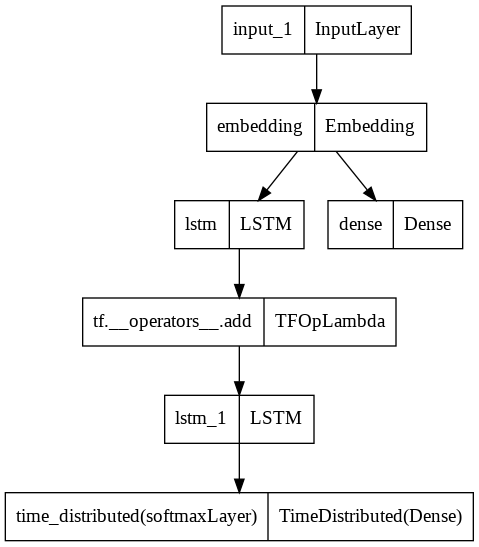

In [74]:
############################
# Training Params
############################

import time

learning_rate = 5e-4
epochs = 40

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = build_model()

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_2.{epoch:02d}-{loss:.2f}.h5'),
]

# Compile
model.compile(loss=[loss, loss],
              loss_weights=[1, 1],    ## add both the losses with equal weights
              optimizer=optimizer,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

dot_img_file = '/tmp/model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False)

In [75]:
# Train model
start_time = time.time()

training_results = model.fit(
        train_data,
        epochs=epochs, 
        verbose=1,
        validation_data=validation_data,
        callbacks=my_callbacks)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/40
380/380 [==============================] - 27s 48ms/step - loss: 1.1518 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.7234 - val_sparse_categorical_accuracy: 0.8882
Epoch 2/40
380/380 [==============================] - 17s 45ms/step - loss: 0.7071 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.6979 - val_sparse_categorical_accuracy: 0.8882
Epoch 3/40
380/380 [==============================] - 17s 45ms/step - loss: 0.6837 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.8882
Epoch 4/40
380/380 [==============================] - 17s 44ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.8912 - val_loss: 0.5955 - val_sparse_categorical_accuracy: 0.9007
Epoch 5/40
380/380 [==============================] - 17s 45ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.5182 - val_sparse_categorical_accuracy: 0.9029
Epoch 6/40
380/380 [==============================] - 17s 44ms/step - loss: 0.4961 - spars

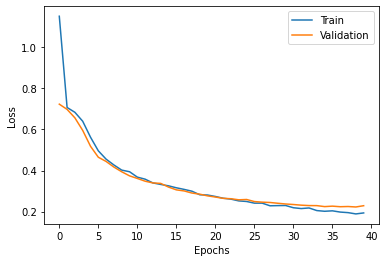

In [76]:
# Plot the trace plot of the loss of the model
plt.plot(training_results.history['loss'], label='Train')
plt.plot(training_results.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc=0)
plt.show()

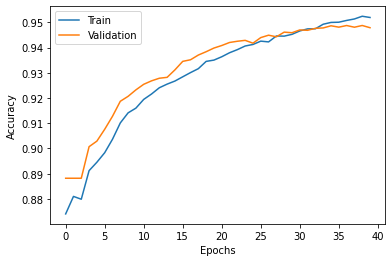

In [77]:
# Plot the trace plot of the loss of the model
plt.plot(training_results.history['sparse_categorical_accuracy'], label='Train')
plt.plot(training_results.history['val_sparse_categorical_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc=0)
plt.show()

In [78]:
# # Plot the trace plot of the accuracy of the predictions made by the model
# average_accuracy = training_results.history['sparse_categorical_accuracy']
# average_val_accuracy = np.add(training_results.history['val_softmaxLayer_sparse_categorical_accuracy'], training_results.history['val_softmaxLayer_1_sparse_categorical_accuracy'])/2
# plt.plot(average_accuracy, label='Train')
# plt.plot(average_val_accuracy, label='Validation')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(loc=0)
# plt.show()

In [79]:
# Your code here

# Helper Code
batch_size = len(test_sentences)
# train_shuffle_buffer_size = len(test_sentences)
# validation_shuffle_buffer_size = len(test_sentences)

# Fill the required cells to complete the function
def transform_pad(input, output):
    
    # Pad the inputs
    input  = input.to_tensor(default_value=0, shape=[None, None])
    
    # Pad the outputs
    output = output.to_tensor(default_value=0, shape=[None, None])
    
    return input, output

# Use tensorflow ragged constants to get the ragged version of data
test_processed_x = tf.ragged.constant(test_sentences)
test_processed_y = tf.ragged.constant(test_tags)

# Create TF Dataset
test_data = tf.data.Dataset.from_tensor_slices((test_processed_x, test_processed_y))

#############
# Test data
#############
# Apply all data processing logic
# train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
test_data = test_data.batch(batch_size)
test_data = test_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

print("test_data", test_data)

test_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [80]:
batch_size

169

In [81]:
# View some data from tf dataset
for input_f, output_f in test_data.take(1):
  print(input_f.shape)
  print(input_f[0])
#   print(input_b[0])
  print("************************")
  print(output_f.shape)
  print(output_f[0])
#   print(output_b[0])

(169, 596)
tf.Tensor(
[   1   86  345    1   13    1    1    1    1    1    1    1    1    5
    1    1   24   57    1    1   10  377  371   31   23    1    1    1
  704   86   41   16  107 1685   56    3  349   56  425    3    5    2
 1378  151  955  110   24   57    2 1824    1    1   10  345    1    5
  434   15 1360    7   30    1    4    2  405    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

In [82]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

In [83]:
predicted_tags = model.predict(test_data).argmax(axis=-1)

In [84]:
predicted_tags_curtailed = []
for i in range(len(predicted_tags)):
    predicted_tags_curtailed.append(predicted_tags[i][:len(test_tags[i])])

In [85]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B-Archive': 0, 'B-CelestialObject': 1, 'B-CelestialObjectRegion': 2, 'B-CelestialRegion': 3, 'B-Citation': 4, 'B-Collaboration': 5, 'B-ComputingFacility': 6, 'B-Database': 7, 'B-Dataset': 8, 'B-EntityOfFutureInterest': 9, 'B-Event': 10, 'B-Fellowship': 11, 'B-Formula': 12, 'B-Grant': 13, 'B-Identifier': 14, 'B-Instrument': 15, 'B-Location': 16, 'B-Mission': 17, 'B-Model': 18, 'B-ObservationalTechniques': 19, 'B-Observatory': 20, 'B-Organization': 21, 'B-Person': 22, 'B-Proposal': 23, 'B-Software': 24, 'B-Survey': 25, 'B-Tag': 26, 'B-Telescope': 27, 'B-TextGarbage': 28, 'B-URL': 29, 'B-Wavelength': 30, 'I-Archive': 31, 'I-CelestialObject': 32, 'I-CelestialObjectRegion': 33, 'I-CelestialRegion': 34, 'I-Citation': 35, 'I-Collaboration': 36, 'I-ComputingFacility': 37, 'I-Database': 38, 'I-Dataset': 39, 'I-EntityOfFutureInterest': 40, 'I-Event': 41, 'I-Fellowship': 42, 'I-Formula': 43, 'I-Grant': 44, 'I-Identifier': 45, 'I-Instrument': 46, 'I-Location': 47, 'I-Mission': 48, 'I-Model': 49,

In [86]:
le_mapping_new = {le_name_mapping[k]: k for k in le_name_mapping.keys()}
le_mapping_new

{0: 'B-Archive',
 1: 'B-CelestialObject',
 2: 'B-CelestialObjectRegion',
 3: 'B-CelestialRegion',
 4: 'B-Citation',
 5: 'B-Collaboration',
 6: 'B-ComputingFacility',
 7: 'B-Database',
 8: 'B-Dataset',
 9: 'B-EntityOfFutureInterest',
 10: 'B-Event',
 11: 'B-Fellowship',
 12: 'B-Formula',
 13: 'B-Grant',
 14: 'B-Identifier',
 15: 'B-Instrument',
 16: 'B-Location',
 17: 'B-Mission',
 18: 'B-Model',
 19: 'B-ObservationalTechniques',
 20: 'B-Observatory',
 21: 'B-Organization',
 22: 'B-Person',
 23: 'B-Proposal',
 24: 'B-Software',
 25: 'B-Survey',
 26: 'B-Tag',
 27: 'B-Telescope',
 28: 'B-TextGarbage',
 29: 'B-URL',
 30: 'B-Wavelength',
 31: 'I-Archive',
 32: 'I-CelestialObject',
 33: 'I-CelestialObjectRegion',
 34: 'I-CelestialRegion',
 35: 'I-Citation',
 36: 'I-Collaboration',
 37: 'I-ComputingFacility',
 38: 'I-Database',
 39: 'I-Dataset',
 40: 'I-EntityOfFutureInterest',
 41: 'I-Event',
 42: 'I-Fellowship',
 43: 'I-Formula',
 44: 'I-Grant',
 45: 'I-Identifier',
 46: 'I-Instrument',
 47

In [87]:
y_pred = np.concatenate(predicted_tags_curtailed).ravel()

In [88]:
y_true = np.concatenate(test_tags).ravel()

In [89]:
(y_pred == 0).sum()

0

In [90]:
for i in range(len(y_pred)):
  if (y_pred[i] > 63) or (y_pred[i] < 1):
    y_pred[i] = 63

In [91]:
y_pred_tag = np.array([le_mapping_new[token-1] for token in y_pred])
y_true_tag = np.array([le_mapping_new[token-1] for token in y_true])

In [92]:
len(y_pred_tag)

54872

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [94]:
print(classification_report(y_true_tag, y_pred_tag, zero_division=0))

                           precision    recall  f1-score   support

                B-Archive       0.45      0.62      0.52        21
        B-CelestialObject       0.69      0.25      0.36       274
  B-CelestialObjectRegion       0.00      0.00      0.00        40
        B-CelestialRegion       0.00      0.00      0.00         7
               B-Citation       0.73      0.34      0.47       543
          B-Collaboration       0.44      0.47      0.46        17
      B-ComputingFacility       0.36      0.23      0.28        39
               B-Database       0.65      0.65      0.65        23
                B-Dataset       0.00      0.00      0.00        12
                  B-Event       0.00      0.00      0.00         1
             B-Fellowship       0.64      0.16      0.25        44
                B-Formula       0.41      0.16      0.23       176
                  B-Grant       0.67      0.67      0.67       580
             B-Identifier       0.74      0.44      0.55     

In [95]:
report = classification_report(y_true_tag, y_pred_tag, zero_division=0, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
B-Archive,0.448276,0.619048,0.520000,21.000000
B-CelestialObject,0.686869,0.248175,0.364611,274.000000
B-CelestialObjectRegion,0.000000,0.000000,0.000000,40.000000
B-CelestialRegion,0.000000,0.000000,0.000000,7.000000
B-Citation,0.730469,0.344383,0.468085,543.000000
...,...,...,...,...
I-Wavelength,0.594937,0.479592,0.531073,98.000000
O,0.944319,0.987365,0.965362,45191.000000
accuracy,0.917718,0.917718,0.917718,0.917718
macro avg,0.453969,0.349889,0.375667,54872.000000


In [96]:
df_report_short = df_report.sort_values(by='support', ascending=False)[:25]
df_report_short

,precision,recall,f1-score,support
weighted avg,0.903745,0.917718,0.906255,54872.0
macro avg,0.453969,0.349889,0.375667,54872.0
O,0.944319,0.987365,0.965362,45191.0
I-Organization,0.857759,0.757230,0.804365,1314.0
I-Citation,0.963474,0.927344,0.945064,1280.0
I-Formula,0.802228,0.704156,0.750000,818.0
B-Organization,0.739193,0.693243,0.715481,740.0
B-Grant,0.667814,0.668966,0.668389,580.0
B-Citation,0.730469,0.344383,0.468085,543.0
B-Person,0.702952,0.798742,0.747792,477.0


In [97]:
df_report_short[df_report_short['f1-score'] < 0.]

,precision,recall,f1-score,support
